# Corona prepping using Finnish data EDA

## Main question: at this point we're interested in one single classification, i.e. __what predicts whether people do maskless contacts with non-householders__

[Research Document](https://docs.google.com/document/d/1iLciHcvVvf8QwFS7wiyNBevpD1B9yDRqMlM4_oCcVcA/edit?usp=sharing)

[Questions codebook](https://docs.google.com/document/d/1YZVCP1UNxnNLAK2kYDfA9Y98leTZYurZD-d8iByhdi0/edit?usp=sharing)

[Method of delivery](https://docs.google.com/document/d/1G1JT9JUJrTK3aaXXuRawYACJaGNxU7mcXL9i-d8eKXY/edit)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import session_info

from neuropy_frequentist_statistics import (normal_check, 
                                            analysis_independent_t_test,
                                            analysis_independent_mannwhitneyu_test,
                                            one_way_ANOVA
                                           )

from neuropy_correlation import correlation_analysis, plot_correlogram

from ml_class import (plot_cv_indices,
                      plot_decision_boundary,
                     plot_learning_curve,
                     multi_roc_auc_plot,
                     dict_of_models,
                     RFE_opt_rf,
                     make_confusion_matrix)

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

/opt/miniconda3/envs/general/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.ensemble import BaggingClassifier
from imblearn.ensemble import BalancedBaggingClassifier

In [3]:
_ = sns.set_style("whitegrid")

### Virtual Environments and Packages

In [4]:
session_info.show(req_file_name="corona_preppers-requirements.txt",
      write_req_file=False) #add write_req_file=True to function to get requirements.txt file of packages used

### Read in data, show info and data head

In [5]:
# # create toy dataset
# np.random.seed(seed=42)
# df = sns.load_dataset(name="iris")
# df["flower_height"] = np.random.lognormal(mean=0, sigma=3, size=len(df)).round(1) # add a non normally distributed column to show the non-parametric tests
# grouping_var = "species"

In [6]:
df = pd.read_csv("data/taloustutkimus_james.csv").drop("ID", axis=1)

In [7]:
df.head()

,PT10_SUKUPUOLI,PT_AGE,PT_MAAKUNTA,PT_SUURALUE,PT_ASUINPAIKKAKUNTA,PT60_KOULUTUS,PT80_AMMATTI,PT90_TALOUDEN_ELINVAIHE,PT110_TALOUDEN_KOKO,PT120_TALOUDEN_BRUTTOTULOT,...,Q61_1,Q62,Q63,Q64,Q65,Q66,Q68_1,Q68_2,Q68_3,kotilasten_iat
0,1,40-49,11,4,6,6,3,2,2,suuri,...,1,3,2,2,2,2,1,2,3,ei_mainittu
1,1,40-49,2,2,8,5,5,4,5,suuri,...,2,3,2,2,2,2,2,2,2,4
2,2,18-29,1,1,1,6,5,1,1,keskisuuri,...,1,3,2,1,3,1,1,3,4,ei_mainittu
3,1,50-59,1,1,2,6,3,3,3,suuri,...,1,3,1,3,2,1,1,1,1,ei_mainittu
4,2,50-59,4,3,8,2,9,4,4,suuri,...,3,1,3,3,2,2,4,4,5,3


### Create a boolean version of the target `kotilasten_iat`

In [8]:
# df = df.assign(kotilasten_iat_bool = lambda x: (x["kotilasten_iat"] != "ei_mainittu").astype(int))

# df["kotilasten_iat"].value_counts()

# df["kotilasten_iat_bool"].value_counts()

### Specify the feature list, grouping variable, and specify the grouping variable as a categorical variable

In [9]:
# Consider the interested group to analyze
grouping_var = "Q5" 

# Consider only numerical features
features_list = df.drop(grouping_var, axis=1).select_dtypes(np.number).columns.tolist()

df[grouping_var] = df[grouping_var].astype("category")

### Creating a boolean version of the grouping variable

In [10]:
df[f"{grouping_var}_bool"] = (df[grouping_var] != 5).astype(int)

In [11]:
print(df[grouping_var].value_counts())
print(df[f"{grouping_var}_bool"].value_counts())

5    881
4    823
3    277
1    165
2    126
Name: Q5, dtype: int64
1    1391
0     881
Name: Q5_bool, dtype: int64


In [12]:
print(df["Q8_3"].value_counts())


3    749
2    623
1    622
4    278
Name: Q8_3, dtype: int64


In [13]:
df.info(max_cols=104)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2272 entries, 0 to 2271
Data columns (total 102 columns):
 #    Column                      Non-Null Count  Dtype   
---   ------                      --------------  -----   
 0    PT10_SUKUPUOLI              2272 non-null   int64   
 1    PT_AGE                      2272 non-null   object  
 2    PT_MAAKUNTA                 2272 non-null   int64   
 3    PT_SUURALUE                 2272 non-null   int64   
 4    PT_ASUINPAIKKAKUNTA         2272 non-null   int64   
 5    PT60_KOULUTUS               2272 non-null   int64   
 6    PT80_AMMATTI                2272 non-null   int64   
 7    PT90_TALOUDEN_ELINVAIHE     2272 non-null   int64   
 8    PT110_TALOUDEN_KOKO         2272 non-null   int64   
 9    PT120_TALOUDEN_BRUTTOTULOT  2272 non-null   object  
 10   PT200_ASUNNON_TYYPPI        2272 non-null   int64   
 11   Q1                          2272 non-null   int64   
 12   Q2                          2272 non-null   int64   
 13   Q

### Distribution plots
Flexible multiplot set of whisker and density plots of all groups

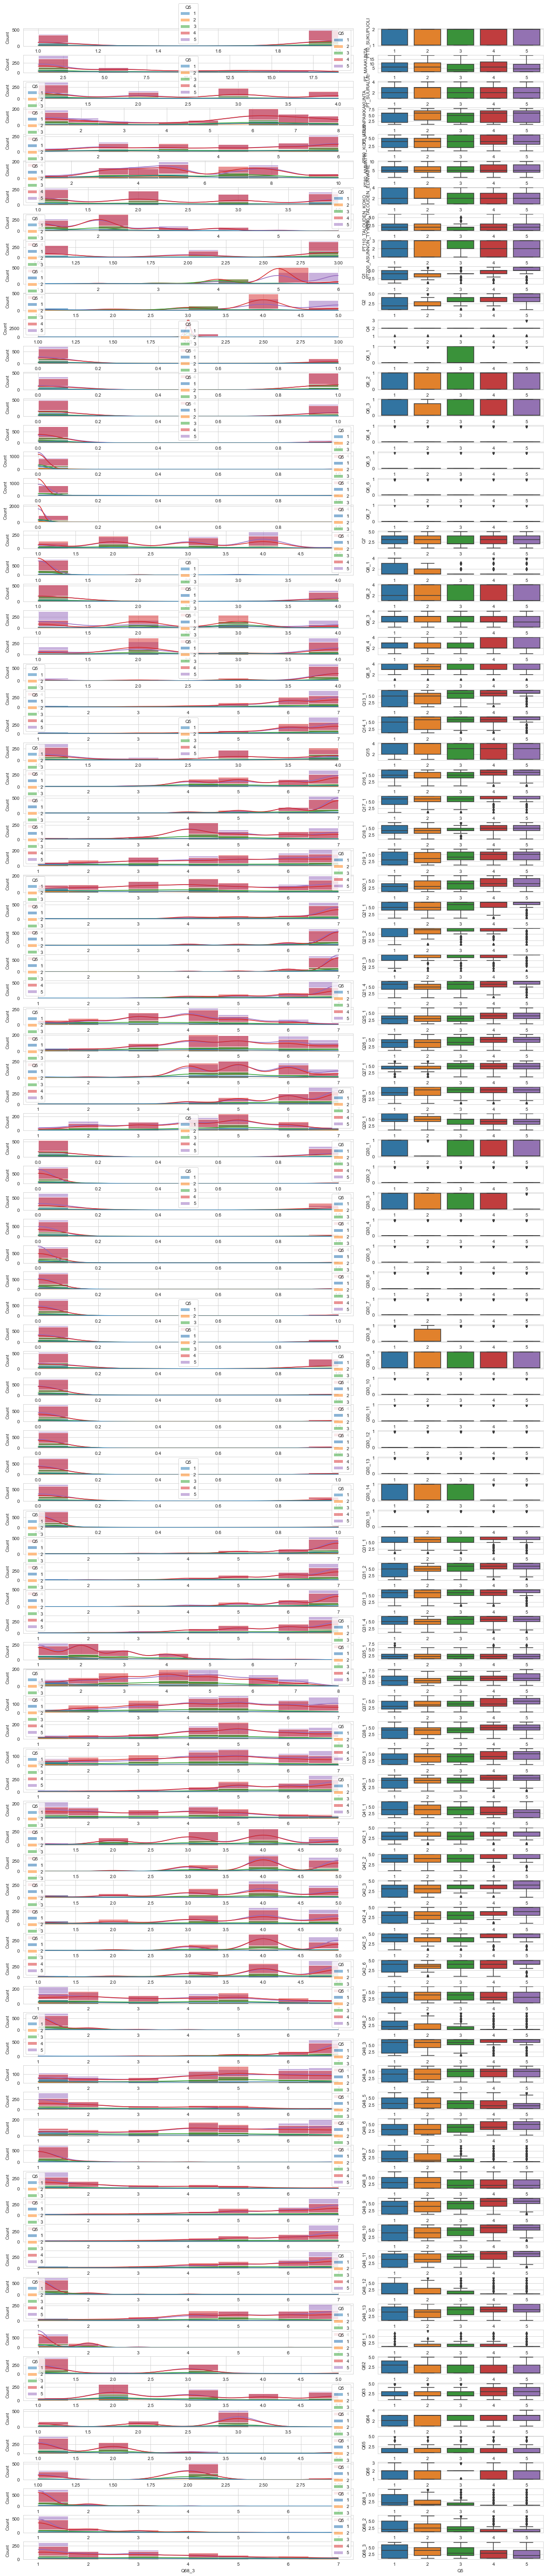

In [14]:
# Plot
set_plot_limits=False
use_boolean = False
fig, axs = plt.subplots(figsize=(20,100), nrows=len(features_list), ncols=2, gridspec_kw={'width_ratios': [2, 1]})
fig.subplots_adjust(hspace = 0.5, wspace=0.1)
axs = axs.ravel()
if use_boolean:
    for i in range(0, len(features_list)*2, 2):
        _ = sns.histplot(data=df, x=features_list[int(i/2)], hue=f"{grouping_var}_bool", kde=True, bins=10, ax=axs[i])
        _ = sns.boxplot(data=df, x=f"{grouping_var}_bool", y=features_list[int(i/2)], ax=axs[i+1])
else:    
    for i in range(0, len(features_list)*2, 2):
        _ = sns.histplot(data=df, x=features_list[int(i/2)], hue=grouping_var, kde=True, bins=10, ax=axs[i])
        _ = sns.boxplot(data=df, x=grouping_var, y=features_list[int(i/2)], ax=axs[i+1])

### Features heatmap

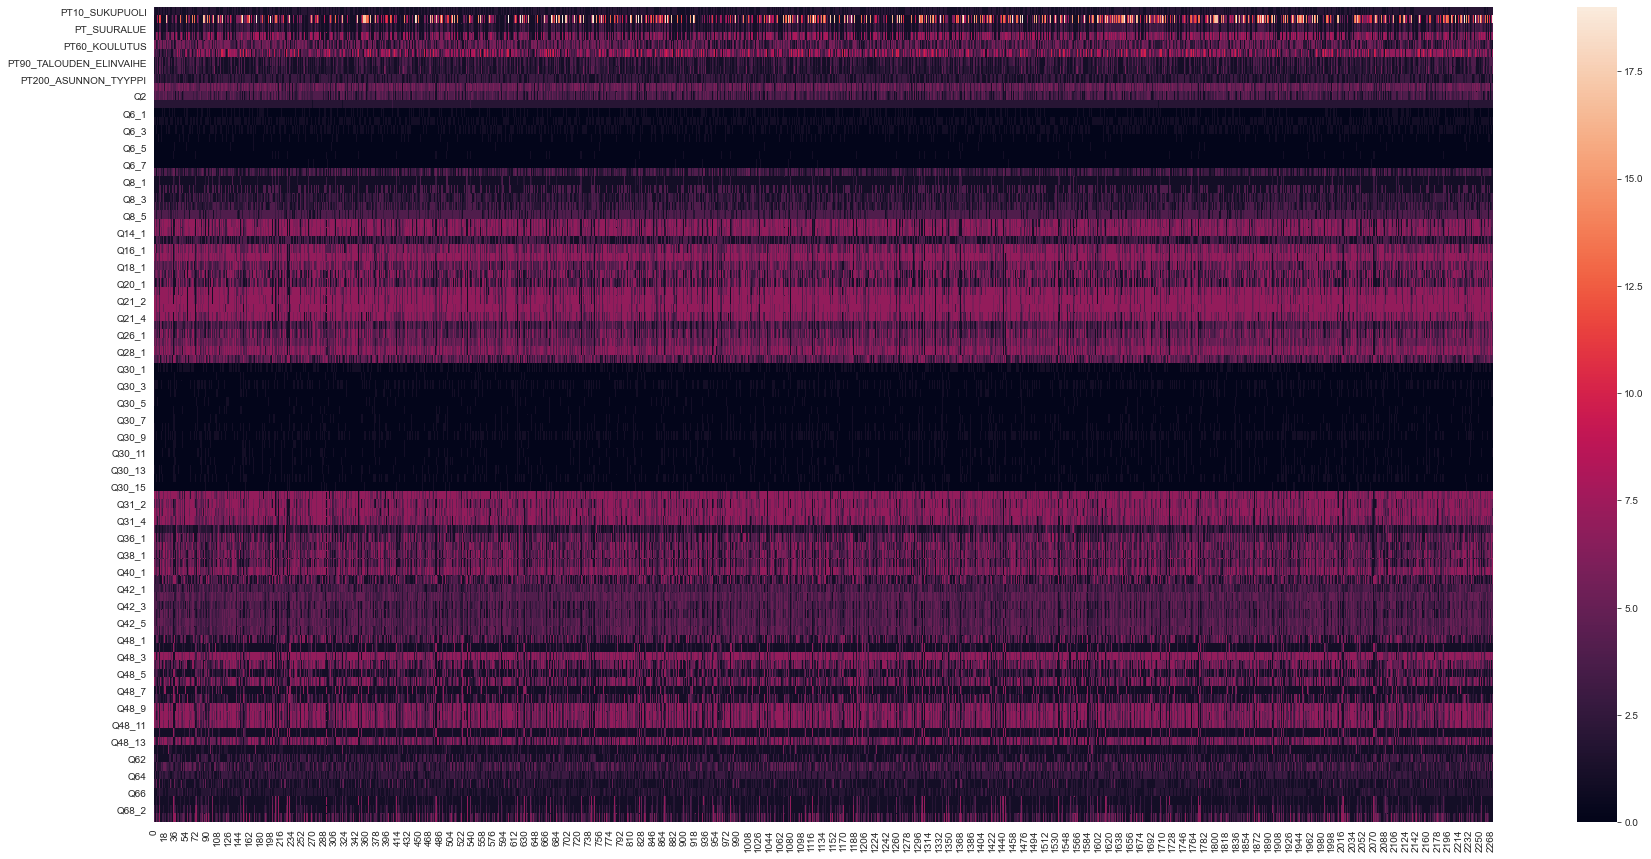

In [15]:
_ = plt.figure(figsize=(30, 15))
_ = sns.heatmap(df[features_list].T)

### Remove columns based on small amount of information (here where there are less than 4 different options in the data)

In [16]:
value_counts_count_df = df[df.drop([grouping_var, f"{grouping_var}_bool"],axis=1).select_dtypes(int).columns.tolist()].apply(lambda x: x.value_counts()).count(axis=0)
features_drop_list = value_counts_count_df[value_counts_count_df < 4].index.tolist()
value_counts_count_df[value_counts_count_df < 4]

PT10_SUKUPUOLI          2
PT200_ASUNNON_TYYPPI    3
Q4                      3
Q6_1                    2
Q6_2                    2
Q6_3                    2
Q6_4                    2
Q6_5                    2
Q6_6                    2
Q6_7                    2
Q30_1                   2
Q30_2                   2
Q30_3                   2
Q30_4                   2
Q30_5                   2
Q30_6                   2
Q30_7                   2
Q30_8                   2
Q30_9                   2
Q30_10                  2
Q30_11                  2
Q30_12                  2
Q30_13                  2
Q30_14                  2
Q30_15                  2
Q66                     3
dtype: int64

### Assign feature list again with suggested features dropped

In [17]:
features_list = list(set(features_list) ^ set(features_drop_list))

### Checking whether a feature is normal or not using kolmogorov smirnov

In [18]:
# subset data frame with only numerical variables
X = df[features_list]
df_normal_check = normal_check(X)

# data frame containing variables with Gaussian distribution
X_normal    = X[df_normal_check.loc[df_normal_check['normality'] == True, 'feature']]

# data frame containing variables with non-Gaussian distribution
X_nonnormal = X[df_normal_check.loc[df_normal_check['normality'] == False, 'feature']]

# Print Info
display(df_normal_check.T)
print("====== Normality test based on Kolmogorov-Smirnov test =====\n")
print(f"- Size normally distributed feature: {X_normal.shape[1]}")
print(f"- Size NOT normally distributed feature: {X_nonnormal.shape[1]}")

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
feature,Q7,Q28_1,Q26_1,Q27_1,Q65,Q42_1,Q31_2,PT_MAAKUNTA,Q18_1,Q31_4,...,Q68_1,Q68_3,Q48_12,Q8_4,Q1,Q42_5,Q19_1,Q42_6,PT110_TALOUDEN_KOKO,PT90_TALOUDEN_ELINVAIHE
p-value,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
normality,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


====== Normality test based on Kolmogorov-Smirnov test =====

- Size normally distributed feature: 0
- Size NOT normally distributed feature: 70


### Simple independent t-tests (and mann whitney if feature is not normal)

In [19]:
t_test_group = f"{grouping_var}_bool" # Set the column which contains categorical variable
group1 = 0        # consider group1, e.g., Healthy Controls
group2 = 1     # consider group2, e.g., Patient affected by Multiple Sclerosis

In [20]:
# Apply t-test for normal features    
if X_normal.shape[1] > 0:
    ttest_df = X_normal.merge(right=df[t_test_group], left_index = True, right_index = True)
    df_analysis_normal, _, _, _ = analysis_independent_t_test(data = ttest_df,
                                                              features = X_normal.columns, 
                                                              grouping_var=t_test_group,
                                                              grouping_grp1 = group1, 
                                                              grouping_grp2 = group2,
                                                              plot = False
                                                             )
    display(df_analysis_normal.round(2))
else:
    print("There were no normal features")

# apply mannwhitneyu for nonnonrmal features
if X_nonnormal.shape[1] > 0:
    mann_df = X_nonnormal.merge(right=df[t_test_group], left_index = True, right_index = True)
    df_analysis_nonnormal, _, _ = analysis_independent_mannwhitneyu_test(data=mann_df,
                                                                         features=X_nonnormal.columns, 
                                                                         grouping_var=t_test_group,
                                                                         grouping_grp1=group1, 
                                                                         grouping_grp2=group2,
                                                                         plot = False
                                                                         )
    display(df_analysis_nonnormal.round(2))
else:
    print("There were no nonnormal features")

There were no normal features


,test-type,feature,group-var,group1,n-sample1,mean1 (std1),group2,n-sample2,mean2 (std2),u-value,p-value,stat-sign
64,independent MannwhitneyU test,Q1,Q5_bool,0,881,5.09 (1.04),1,1391,4.34 (1.15),366138.5,0.00,True
23,independent MannwhitneyU test,Q2,Q5_bool,0,881,3.84 (1.17),1,1391,3.27 (1.15),429173.5,0.00,True
18,independent MannwhitneyU test,Q21_4,Q5_bool,0,881,6.23 (1.23),1,1391,5.55 (1.60),453691.0,0.00,True
22,independent MannwhitneyU test,Q48_10,Q5_bool,0,881,5.80 (1.55),1,1391,4.99 (1.94),460921.5,0.00,True
56,independent MannwhitneyU test,Q48_11,Q5_bool,0,881,5.69 (1.58),1,1391,4.94 (1.91),467943.0,0.00,True
...,...,...,...,...,...,...,...,...,...,...,...,...
16,independent MannwhitneyU test,PT80_AMMATTI,Q5_bool,0,881,5.45 (2.35),1,1391,5.58 (2.32),596159.0,0.14,False
41,independent MannwhitneyU test,Q8_2,Q5_bool,0,881,2.19 (1.46),1,1391,2.12 (1.41),600026.0,0.17,False
54,independent MannwhitneyU test,Q35_1,Q5_bool,0,881,2.29 (1.26),1,1391,2.32 (1.25),602110.5,0.23,False
68,independent MannwhitneyU test,PT110_TALOUDEN_KOKO,Q5_bool,0,881,2.19 (1.17),1,1391,2.15 (1.12),603983.5,0.27,False


### Simple ANOVAs to check multiple groups

In [21]:
anova_results = pd.DataFrame() # Pre-allocation

# Run ANOVA only with features with normal distribution
for feature in X_normal.columns.tolist():
    anova_df = X_normal.merge(right=df[grouping_var], left_index = True, right_index = True)
    df_result, df_descriptive, _, _ = one_way_ANOVA(data=anova_df, feature=feature,
                                                    grouping_var=grouping_var,
                                                    groups_of_interest=df[grouping_var].unique().tolist(),
                                                    show=False,
                                                    plot=False,
                                                    figsize=(11.7, 8.27),
                  col_wrap=None,)
    anova_results = pd.concat([anova_results, df_result])

# print results
anova_results

""


In [22]:
dict_results, fig_permutations = correlation_analysis(data=df[features_list+["Q5"]],
#                          col_list=,
#                          row_list=features_list,
                         check_norm=True,
                         method = 'pearson',
                         dropna = 'pairwise',)

cors = dict_results["summary"]

In [23]:
cors[cors["stat-sign"]].loc[cors["r-value"] > 0.7, :]

,analysis,feature1,feature2,r-value,p-value,stat-sign,N
173,Spearman Rank,Q26_1,Q25_1,0.701495,0.0,True,2272
465,Spearman Rank,PT_MAAKUNTA,PT_SUURALUE,0.928052,0.0,True,2272
494,Spearman Rank,PT_MAAKUNTA,PT_ASUINPAIKKAKUNTA,0.711415,0.0,True,2272
732,Spearman Rank,PT_SUURALUE,PT_ASUINPAIKKAKUNTA,0.704885,0.0,True,2272
783,Spearman Rank,Q14_1,Q13_1,0.809850,0.0,True,2272
919,Spearman Rank,Q39_1,Q38_1,0.756000,0.0,True,2272
1307,Spearman Rank,Q48_10,Q48_3,0.772274,0.0,True,2272
1313,Spearman Rank,Q48_10,Q48_9,0.840405,0.0,True,2272
1320,Spearman Rank,Q48_10,Q48_11,0.853407,0.0,True,2272
1771,Spearman Rank,Q42_4,Q48_11,0.735637,0.0,True,2272


In [24]:
cor_feat_1_list = cors[cors["stat-sign"]].loc[cors["r-value"] > 0.7, :].feature1.tolist()
cor_feat_2_list = cors[cors["stat-sign"]].loc[cors["r-value"] > 0.7, :].feature2.tolist()

In [25]:
hi_r_value_features = list(set(cor_feat_1_list) ^ set(cor_feat_2_list))

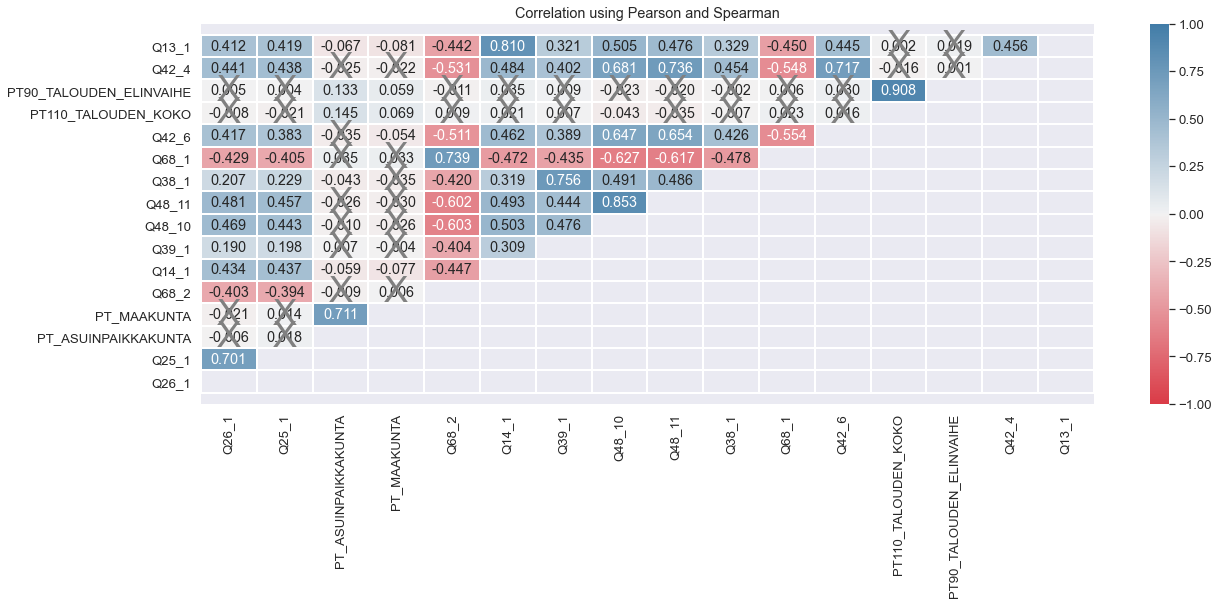

In [26]:
_ = plot_correlogram(data=df[hi_r_value_features],
#     row_list=cor_feat_1_list,
#     col_list=cor_feat_2_list,
    check_norm=True,
                    figsize=(20,7))

### Plot the decision boundaries of a few example classifiers

In [27]:
decision_tree_features = value_counts_count_df.sort_values().tail(2).index.tolist()

In [28]:
grouping_var = "Q5_bool" #"Q5_bool"
y = df[grouping_var]
X = df[decision_tree_features]
decision_tree_features

['PT80_AMMATTI', 'PT_MAAKUNTA']

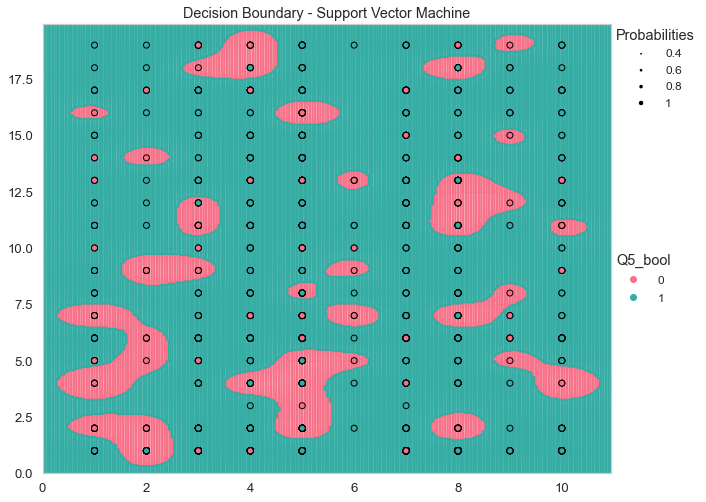

In [29]:
_ = sns.set_style("whitegrid")
clf = SVC(kernel="rbf", gamma=2, C=1, probability=True)
_ = plot_decision_boundary(X=X, y=y, clf=clf, title = 'Decision Boundary - Support Vector Machine', legend_title = f"{grouping_var}")

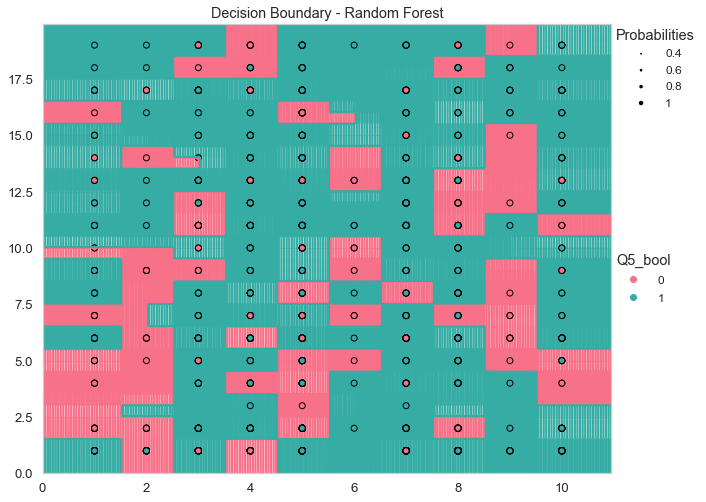

In [30]:
clf = RandomForestClassifier()
_ = plot_decision_boundary(X=X, y=y, clf=clf, title = 'Decision Boundary - Random Forest', legend_title = f"{grouping_var}")

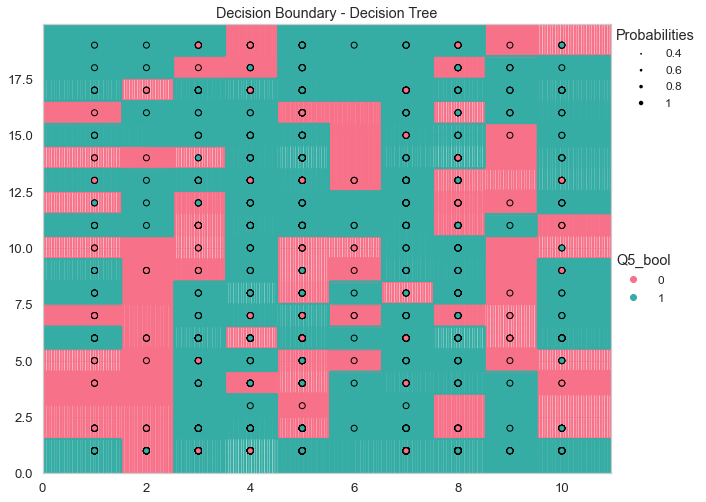

In [31]:
clf = DecisionTreeClassifier()
_ = plot_decision_boundary(X=X, y=y, clf=clf, title = 'Decision Boundary - Decision Tree', legend_title = f"{grouping_var}")

### Plot the learning curve of the latest classifier

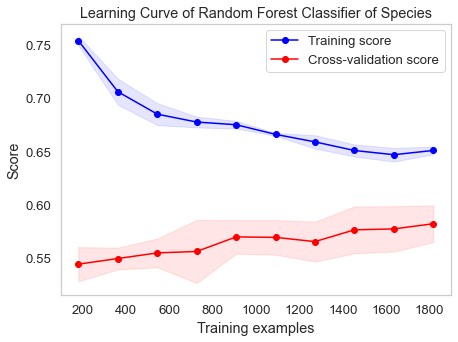

In [32]:
fig = plot_learning_curve(estimator=clf, 
                          title="Learning Curve of Random Forest Classifier of Species",
                          X=X, 
                          y=y,
                          groups=None, 
                          cross_color="red", 
                          test_color="blue", 
                          ylim=None, 
                          cv=None, 
                          n_jobs=None, 
                          train_sizes=np.linspace(.1, 1.0, 10), 
                          figsize=(7,5))

### Plot the confusion matrix of the latest classifier

In [33]:
y_pred = clf.predict(X)
cf_matrix = confusion_matrix(y.astype("category").cat.codes, y_pred)
# accuracy_score(y.astype("category").cat.codes, y_pred)
# _ = sns.heatmap(cf_matrix/ np.sum(cf_matrix), 
#                 fmt=".2%",
#                 annot=True, 
#                cmap="Blues")
# _ = plt.ylabel("Predicted")
# _ = plt.xlabel("Actual")
# _ = plt.title("Confusion Matrix")

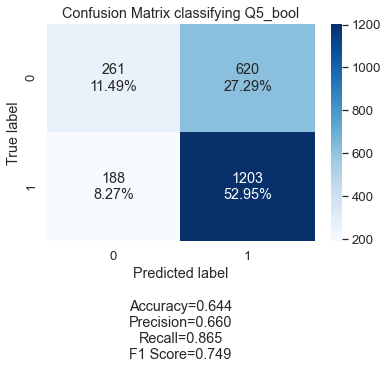

In [34]:
_ = make_confusion_matrix(cf=cf_matrix, 
                      title=f"Confusion Matrix classifying {grouping_var}",
                     sum_stats=True)

### Run a RFE on a random forest to get the most important features of an optimized random forest

In [35]:
grouping_var = "Q5_bool"
y = df[grouping_var]
X = df[features_list]

In [36]:
n_features_to_select = 3 #[1, 2, 5, 10, 50, 100]
max_depth = [1, 2, 5, 10, 50, 100]
n_estimators = [1, 2, 5, 10, 50, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300]

(feature_ranking, feature_selected, feature_importance, max_depth, n_estimators, max_features, criterion) = RFE_opt_rf(X , y, n_features_to_select, max_depth, n_estimators)

Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 fe

In [37]:
feature_importance_df = pd.DataFrame(feature_importance.sort_values(ascending=False)).reset_index().rename(columns={"index": "feature", 0: "feature_importance"})

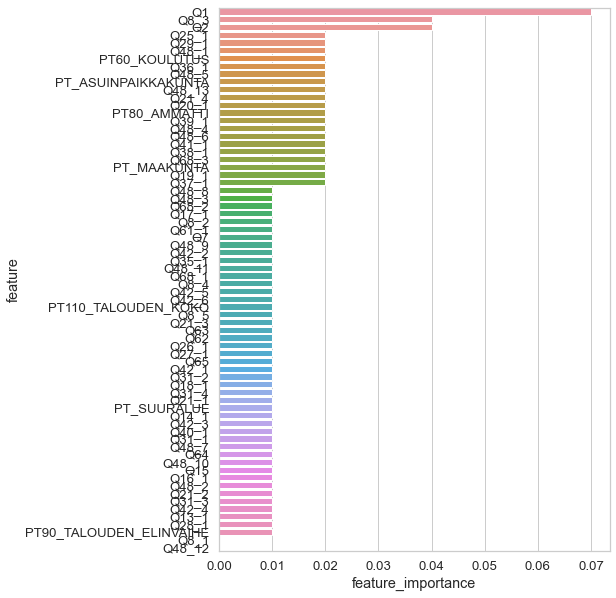

In [38]:
_ = plt.figure(figsize=(7, 10))
_ = sns.barplot(data=feature_importance_df, x="feature_importance", y="feature")

In [39]:
feature_selected = feature_importance_df.head(3)["feature"].tolist()
feature_selected

['Q1', 'Q8_3', 'Q2']

### Make the problem a binary classification and plot the roc curves of a dictionary of models

In [40]:
grouping_var = "Q5_bool"
y = df[grouping_var]
X = df[feature_selected]

In [41]:
dict_of_models

[{'label': 'Logistic Regression', 'model': LogisticRegression()},
 {'label': 'Gradient Boosting', 'model': GradientBoostingClassifier()},
 {'label': 'K_Neighbors Classifier',
  'model': KNeighborsClassifier(n_neighbors=3)},
 {'label': 'SVM Classifier (linear)',
  'model': SVC(C=0.025, kernel='linear', probability=True)},
 {'label': 'SVM Classifier (Radial Basis Function; RBF)',
  'model': SVC(C=1, gamma=2, probability=True)},
 {'label': 'Gaussian Process Classifier',
  'model': GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))},
 {'label': 'Decision Tree (depth=5)',
  'model': DecisionTreeClassifier(max_depth=5)},
 {'label': 'Random Forest Classifier(depth=5)',
  'model': RandomForestClassifier(max_depth=5, max_features=1, n_estimators=10)},
 {'label': 'Multilayer Perceptron (MLP) Classifier',
  'model': MLPClassifier(alpha=1, max_iter=1000)},
 {'label': 'AdaBoost Classifier', 'model': AdaBoostClassifier()},
 {'label': 'Naive Bayes (Gaussian) Classifier', 'model': GaussianNB

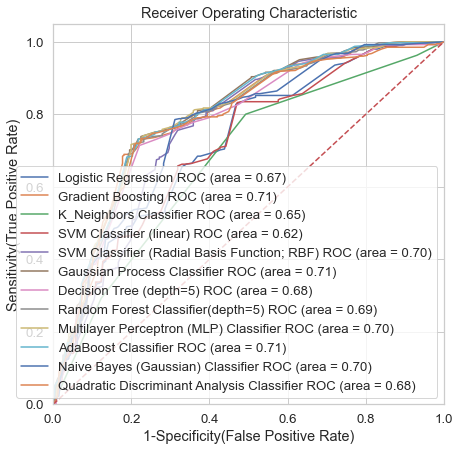

In [42]:
_ = multi_roc_auc_plot(X=X, 
                       y=y, 
                       models=dict_of_models)

In [43]:
# define model
# model = BaggingClassifier()

base_model = DecisionTreeClassifier()
# base_model = SVC(kernel="rbf", gamma=2, C=1, probability=True)
# base_model = SVC(kernel="linear", gamma=2, C=1, probability=True)
# base_model = RandomForestClassifier(max_depth=max_depth, 
#                              n_estimators=n_estimators, 
#                              max_features=max_features, 
#                              criterion=criterion)

model = BalancedBaggingClassifier(base_estimator=base_model, replacement=True)

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.762


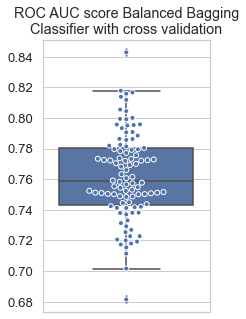

In [44]:
_ = plt.figure(figsize=(3,5))
_ = sns.boxplot(y = scores)
_ = sns.swarmplot(y = scores, edgecolor="white", linewidth=1)
_ = plt.title("ROC AUC score Balanced Bagging\nClassifier with cross validation")

In [45]:
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

>Train: 0=699, 1=1118, Test: 0=182, 1=273


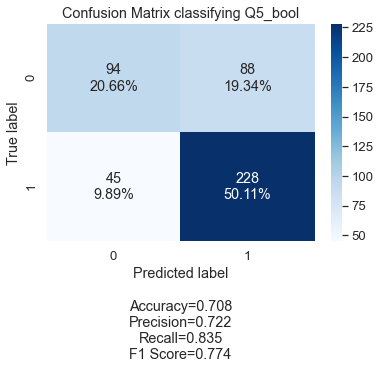

>Train: 0=720, 1=1097, Test: 0=161, 1=294


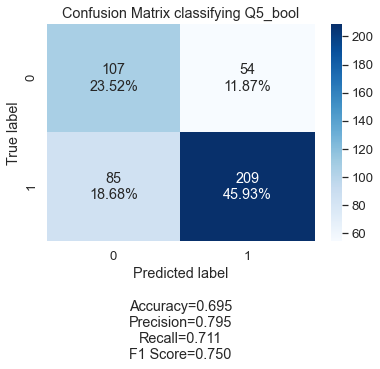

>Train: 0=698, 1=1120, Test: 0=183, 1=271


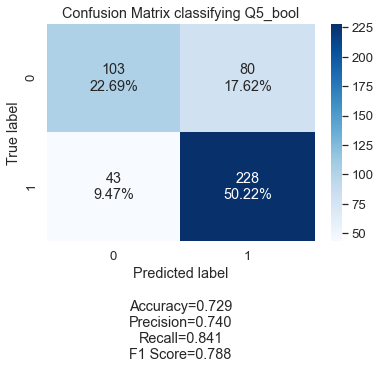

>Train: 0=704, 1=1114, Test: 0=177, 1=277


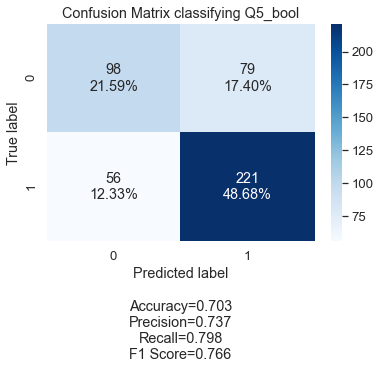

>Train: 0=703, 1=1115, Test: 0=178, 1=276


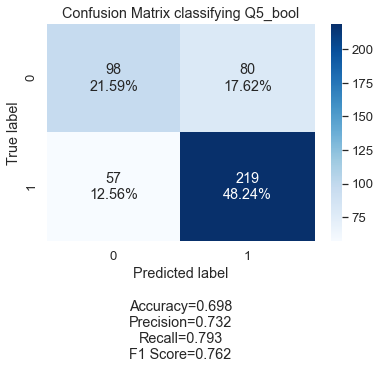

In [46]:
clf = RandomForestClassifier(max_depth=max_depth, 
                             n_estimators=n_estimators, 
                             max_features=max_features, 
                             criterion=criterion)
# clf = SVC(kernel="linear", gamma=2, C=1, probability=True)
# example of k-fold cross-validation with an imbalanced dataset
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(X):
    # select rows
    train_X, test_X = X.loc[train_ix, :], X.loc[test_ix, :]
    train_y, test_y = y.loc[train_ix], y.loc[test_ix]
    # summarize train and test composition
    train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
    print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))
    
    _ = clf.fit(X = train_X, 
                y = train_y)
    
    pred_y = clf.predict(test_X)
    cf_matrix = confusion_matrix(test_y, pred_y)
    
    _ = make_confusion_matrix(cf=cf_matrix, 
                      title=f"Confusion Matrix classifying {grouping_var}",
                     sum_stats=True)
    _ = plt.show()